Fitting 4 folds for each of 2 candidates, totalling 8 fits

✅ Best Parameters: {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}

Cross-validation F1-macro scores: [0.56620181 0.56492855 0.5553156  0.58002856]
Mean CV F1-macro score: 0.5666

📊 Validation Classification Report:
              precision    recall  f1-score   support

         AFM       0.35      0.21      0.26       547
          FM       0.79      0.85      0.82      5766
         FiM       0.48      0.28      0.35       822
          NM       0.86      0.88      0.87      4107

    accuracy                           0.79     11242
   macro avg       0.62      0.56      0.58     11242
weighted avg       0.77      0.79      0.78     11242



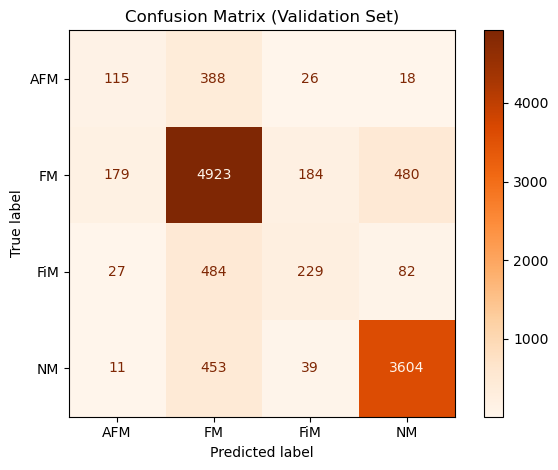


🧪 Test Classification Report:
              precision    recall  f1-score   support

         AFM       0.34      0.21      0.26       547
          FM       0.79      0.86      0.82      5766
         FiM       0.49      0.29      0.36       822
          NM       0.87      0.88      0.87      4107

    accuracy                           0.79     11242
   macro avg       0.62      0.56      0.58     11242
weighted avg       0.77      0.79      0.78     11242



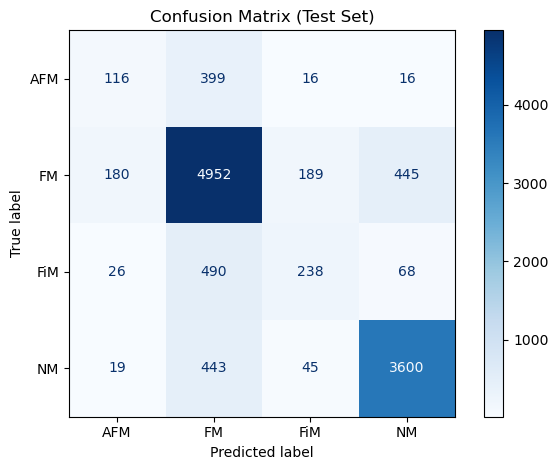


📈 F1-Macro Scores for Overfitting Check:
Training F1-Macro Score:   1.0000
Validation F1-Macro Score: 0.5757
Test F1-Macro Score:       0.5802


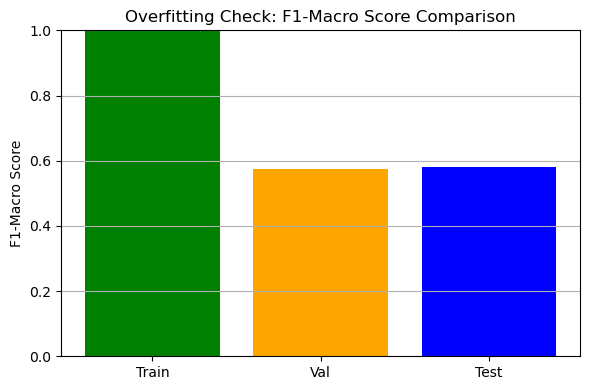

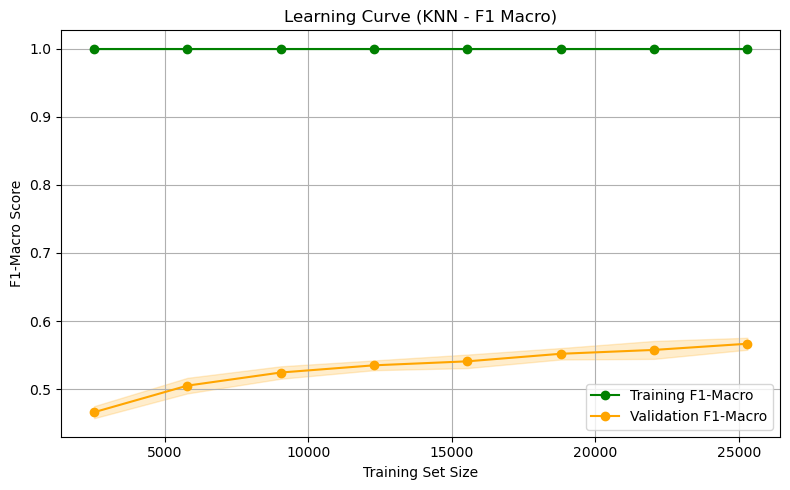

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.neighbors import KNeighborsClassifier

# Load data
df = pd.read_csv("Materials_With_AtLeast_OneMagneticElement.csv")

# Parse elements
def parse_elements(val):
    if pd.isna(val):
        return []
    return [e.strip().split()[-1] for e in str(val).strip("[]").split(",")]
df["elements"] = df["elements"].apply(parse_elements)

# Extract crystal system
def extract_crystal_system(symmetry_str):
    if pd.isna(symmetry_str):
        return "Unknown"
    match = re.search(r"crystal_system=<CrystalSystem\.\w+: '(\w+)'", str(symmetry_str))
    return match.group(1) if match else "Unknown"
df["crystal_system"] = df["symmetry"].apply(extract_crystal_system)

# Drop missing values
numerical_features = ["cbm", "vbm", "energy_above_hull", "band_gap", "density_atomic",
                      "numberofelements", "volume", "nsites", "density", "efermi", "formation_energy_per_atom"]
df = df.dropna(subset=numerical_features + ["ordering"])

# One-hot encode
mlb = MultiLabelBinarizer()
element_df = pd.DataFrame(mlb.fit_transform(df["elements"]), columns=mlb.classes_)
crystal_df = pd.get_dummies(df["crystal_system"], prefix="crysys")

# Combine features
X_raw = pd.concat([
    df[numerical_features].reset_index(drop=True),
    element_df.reset_index(drop=True),
    crystal_df.reset_index(drop=True)
], axis=1)

# Encode target
le = LabelEncoder()
y = le.fit_transform(df["ordering"])

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

# Split data
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# Grid Search
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
param_grid = {
    'n_neighbors': [5],
    'weights': ['distance'],
    'p': [1]
}

grid_search = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    scoring='f1_macro',
    cv=skf,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)
best_knn = grid_search.best_estimator_
print(f"\n✅ Best Parameters: {grid_search.best_params_}\n")

# Cross-validation scores
cv_scores = cross_val_score(best_knn, X_train, y_train, cv=skf, scoring='f1_macro', n_jobs=-1)
print(f"Cross-validation F1-macro scores: {cv_scores}")
print(f"Mean CV F1-macro score: {cv_scores.mean():.4f}")

# Validation evaluation
y_pred_val = best_knn.predict(X_val)
print("\n📊 Validation Classification Report:")
print(classification_report(y_val, y_pred_val, target_names=le.classes_))
ConfusionMatrixDisplay(confusion_matrix(y_val, y_pred_val), display_labels=le.classes_).plot(cmap="Oranges", values_format="d")
plt.title("Confusion Matrix (Validation Set)")
plt.tight_layout()
plt.show()

# Test evaluation
y_pred_test = best_knn.predict(X_test)
print("\n🧪 Test Classification Report:")
print(classification_report(y_test, y_pred_test, target_names=le.classes_))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test), display_labels=le.classes_).plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()

# Overfitting check
y_pred_train = best_knn.predict(X_train)
f1_train = f1_score(y_train, y_pred_train, average='macro')
f1_val = f1_score(y_val, y_pred_val, average='macro')
f1_test = f1_score(y_test, y_pred_test, average='macro')
print("\n📈 F1-Macro Scores for Overfitting Check:")
print(f"Training F1-Macro Score:   {f1_train:.4f}")
print(f"Validation F1-Macro Score: {f1_val:.4f}")
print(f"Test F1-Macro Score:       {f1_test:.4f}")

plt.figure(figsize=(6, 4))
plt.bar(['Train', 'Val', 'Test'], [f1_train, f1_val, f1_test], color=['green', 'orange', 'blue'])
plt.ylabel('F1-Macro Score')
plt.title('Overfitting Check: F1-Macro Score Comparison')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Learning curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_knn,
    X=X_train,
    y=y_train,
    cv=skf,
    scoring='f1_macro',
    train_sizes=np.linspace(0.1, 1.0, 8),
    n_jobs=-1
)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, 'o-', label="Training F1-Macro", color="green")
plt.plot(train_sizes, val_mean, 'o-', label="Validation F1-Macro", color="orange")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="green")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color="orange")
plt.title("Learning Curve (KNN - F1 Macro)")
plt.xlabel("Training Set Size")
plt.ylabel("F1-Macro Score")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()
